In [1]:
import openmc
import openmc.data as data
import numpy as np
import matplotlib.pyplot as plt
import scipy as scp
import matplotlib.patches as ptc
import matplotlib as mpl
params = {'image.aspect':'equal',
          'savefig.dpi':600,
          'axes.grid':True,
          'font.size':12,
          'text.usetex':True,
          'text.color':'black'}

mpl.rcParams.update(params)

# Helper Functions

In [2]:
def at2wt(*args):
    wt_dict = {}
    for iso, at in args:
        mass = data.atomic_mass(iso)
        wt_dict[iso] = at * mass
        
    denom = sum(wt_dict.values())
    
    for iso in wt_dict.keys():
        wt_dict[iso] /= denom
    return wt_dict 

def alpha(T):
    return -0.4247 + 1.282e-3 * T + 7.362e-7 * T**2 - 2.069e-10 * T**3

def density(T, rho0, t0 = 25):
    differential = T - t0
    return rho0 / (1 + 3 * alpha(T) * differential)

def fuel_density(T):
    U_rho = 19360 - 1.03347 * T
    Zr_rho = 6550 - 0.1685 * T
    atZr = .2245
    return (atZr * Zr_rho + (1-atZr) * U_rho)

def sodium_density(T):
    temps = np.array([126.85, 226.85, 326.85, 426.85, 526.85, 626.85, 726.85])
    rhos = np.array([919, 897, 874, 852, 828, 805, 781])
    rho_func = scp.interpolate.interp1d(temps,rhos)
    return np.float64(rho_func(T))

# Materials

In [3]:
def mat_volume(num_assems):
    slugs_p_assembly = 127
    core_height = 150.0
    fuel_radius = 1.1261 / 2

    volume = np.pi * fuel_radius**2 * core_height
    return volume * num_assems * slugs_p_assembly

def fuel(at, num_assems ,suffix='',temp = 507.5):
    
    u235 = ('U235', at)
    u238 = ('U238', 1-at)
    wt = at2wt(u235, u238)['U235']
    
    mat = openmc.Material(name=f'fuel_{suffix}', temperature=temp)
    
    mat.add_element('Zr', .1, 'wo')
    mat.add_nuclide('U235', 0.9*wt, 'wo')
    mat.add_nuclide('U238', 0.9*(1-wt), 'wo')
    mat.set_density('kg/m3', fuel_density(temp))
    mat.volume = mat_volume(num_assems)
    return mat

def sodium(temp, name):
    mat = openmc.Material(name=name, temperature=temp)
    
    mat.add_element('Na', 1.0)
    mat.set_density('kg/m3', sodium_density(temp))
    return mat

def cladding(temp):
    mat = openmc.Material(name='cladding', temperature=temp)
    
    mat.add_element('Fe', 85.007, 'wo')
    mat.add_element('Cr', 11.79 , 'wo')
    mat.add_element('Mo', 0.99  , 'wo')
    mat.add_element('Mn', 0.59  , 'wo')
    mat.add_element('Ni', 0.53  , 'wo')
    mat.add_element('W' , 0.45  , 'wo')
    mat.add_element('V' , 0.31  , 'wo')
    mat.add_element('C' , 0.19  , 'wo')
    mat.add_element('Si', 0.10  , 'wo')
    mat.add_element('Nb', 0.02  , 'wo')
    mat.add_element('P' , 0.019 , 'wo')
    mat.add_element('N' , 0.01  , 'wo')
    mat.add_element('S' , 0.004 , 'wo')

    rho0 = 7700.0
    mat.set_density('kg/m3', density(temp, rho0))
    return mat

def control_rod(temp):
    mat = openmc.Material(name='control_rod', temperature=temp)

    mat.add_elements_from_formula('C4B')

    rho0 = 2520
    mat.set_density('kg/m3', density(temp, rho0))
    return mat

In [4]:
inner_fuel = fuel(.109, 30, 'inner')
middle_fuel = fuel(.124, 33, 'middle')
outer_fuel = fuel(.155, 36, 'outer')

bond = sodium(497.5, 'bond')
coolant = sodium(432.5, 'coolant')

clad = cladding(482.5)

cntrl_rod = control_rod(450.0) # dont know cr temp

MATERIALS = openmc.Materials([inner_fuel, middle_fuel, outer_fuel, bond, coolant, clad, cntrl_rod])

# Geometry

In [5]:
# PARAMETERS

# Core
core_height = 150.0
core_diameter = 277.6

# Assembly
inner_assembly_edge_length = 9.815
inner_assembly_diameter = 17.0

outer_assembly_edge_length = 9.915
outer_assembly_diameter = 17.173

assembly_pitch = 17.173

# Fuel Slugs
fuel_radius = 1.126 / 2

clad_inner_radius = 1.300 / 2
clad_outer_radius = 1.400 / 2

slug_pitch = 1.501

fuel_rows = 7
num_slugs_per_assembly = 127


# Control Rods
primary_rod_radius = 1.3 /2
primary_clad_radius = 1.4 /2
primary_rod_pitch = 1.801
primary_rows = 6
primary_rods_per_assembly = 91
primary_rod_depth = (1-.9254) * core_height

secondary_rod_radius = 1.950/2
secondary_clad_radius = 2.050/2
secondary_rod_pitch = 2.877
secondary_rows = 4
secondary_rods_per_assembly = 37
secondary_rod_depth = (1-0.5) * core_height


# Reflectors
reflector_radius = 3.000 /2
reflector_pitch = 4.041
reflector_rows = 3
reflectors_per_assembly = 19

In [6]:
def FuelSlug(where):

    fuel_fills = {'inner':inner_fuel, 'middle':middle_fuel, 'outer':outer_fuel}

    # Surfaces
    fuel_outer = openmc.ZCylinder(r=fuel_radius)
    clad_inner = openmc.ZCylinder(r=clad_inner_radius)
    clad_outer = openmc.ZCylinder(r=clad_outer_radius)

    # Fuel Cell
    fuel_cell = openmc.Cell(name='Fuel')
    fuel_cell.region = -fuel_outer
    fuel_cell.fill = fuel_fills[where]

    # Bond Cell
    bond_cell = openmc.Cell(name='Bond')
    bond_cell.region = +fuel_outer & -clad_inner
    bond_cell.fill = bond

    # Clad Cell
    clad_cell = openmc.Cell(name='Fuel Clad')
    clad_cell.region = +clad_inner & -clad_outer
    clad_cell.fill = clad

    # Coolant Cell
    coolant_cell = openmc.Cell(name='Fuel Coolant')
    coolant_cell.region = +clad_outer
    coolant_cell.fill = coolant

    universe = openmc.Universe(name = 'Slug Universe', cells = [fuel_cell, bond_cell, clad_cell, coolant_cell])
    return universe

def ControlRod(rod_radius, clad_radius, name):

    # Surfaces
    rod_outer = openmc.ZCylinder(r=rod_radius)
    clad_outer = openmc.ZCylinder(r=clad_radius)

    # Control Rod Cell
    cr_cell = openmc.Cell(name='Control Rod')
    cr_cell.region = -rod_outer
    cr_cell.fill = cntrl_rod

    #Clad Cell
    clad_cell = openmc.Cell(name='CR Clad')
    clad_cell.region = +rod_outer & -clad_outer
    clad_cell.fill = clad

    # Coolant Cell
    coolant_cell = openmc.Cell(name = 'CR Coolant')
    coolant_cell.region = +clad_outer
    coolant_cell.fill = coolant

    universe = openmc.Universe(name=name, cells = [cr_cell, clad_cell, coolant_cell])    
    return universe

def Reflector():
    
    # Surfaces
    reflector_outer = openmc.ZCylinder(r=reflector_radius)

    # Reflector Cell
    ref_cell = openmc.Cell(name='Reflector')
    ref_cell.region = -reflector_outer
    ref_cell.fill = clad

    # Coolant Cell
    coolant_cell = openmc.Cell(name = 'CR Coolant')
    coolant_cell.region = +reflector_outer
    coolant_cell.fill = coolant

    universe = openmc.Universe(name = 'Reflector', cells = [ref_cell, coolant_cell])
    return universe

def Assembly(fill_universe, pitch, num_rings, depth=None):
    
    # Lattice
        # Universe fills
    universes_per_ring = [ring * (6) for ring in list(range(num_rings-1,0, -1))] + [1]
    lattie_universes =[[fill_universe]*num for num in universes_per_ring]
        # Lattice definition
    lattice = openmc.HexLattice()
    lattice.pitch = (pitch,)
    lattice.center = (0.0, 0.0) 
    lattice.outer = openmc.Universe(cells=[openmc.Cell(fill=coolant)])
    lattice.universes = lattie_universes

    # Assembly
    assembly_clad_inner = openmc.model.HexagonalPrism(edge_length=inner_assembly_edge_length)
    assembly_clad_outer = openmc.model.HexagonalPrism(edge_length=outer_assembly_edge_length)
    if depth:
        clad_thickness = (outer_assembly_diameter - inner_assembly_diameter)/2
        clad_lower = openmc.ZPlane(z0=depth)
        clad_upper = openmc.ZPlane(z0=depth+clad_thickness)
        
        assembly_slugs_cell = openmc.Cell(fill = lattice, region=-assembly_clad_inner & +clad_upper)
        assembly_clad_cell_rad = openmc.Cell(fill = clad, region = +assembly_clad_inner & -assembly_clad_outer & +clad_upper)
        assembly_clad_cell_axial = openmc.Cell(fill = clad, region = -assembly_clad_outer & +clad_lower & -clad_upper)
        lower_coolant_cell = openmc.Cell(fill = coolant, region=-assembly_clad_outer & -clad_lower)
        universe = openmc.Universe(cells=[assembly_slugs_cell, assembly_clad_cell_rad, assembly_clad_cell_axial, lower_coolant_cell])
        
    else:
        assembly_slugs_cell = openmc.Cell(fill = lattice, region=-assembly_clad_inner)
        assembly_clad_cell = openmc.Cell(fill = clad, region = +assembly_clad_inner & -assembly_clad_outer)
        universe = openmc.Universe(cells=[assembly_slugs_cell, assembly_clad_cell])

    return universe

def CoolantAssembly():
    # Surfaces
    clad_inner = openmc.model.HexagonalPrism(edge_length=inner_assembly_edge_length)
    clad_outer = openmc.model.HexagonalPrism(edge_length=outer_assembly_edge_length)

    coolant_cell = openmc.Cell(name = 'All Coolant')
    coolant_cell.region = -clad_inner
    coolant_cell.fill = coolant

    clad_cell = openmc.Cell(name = 'AC Clad')
    clad_cell.region = -clad_outer & +clad_inner
    clad_cell.fill = clad

    universe = openmc.Universe(name = 'All Coolant', cells = [coolant_cell, clad_cell])
    return universe

def EmptyAssembly():
    # Surfaces
    outer = openmc.model.HexagonalPrism(edge_length=outer_assembly_edge_length)

    # Empty Cell
    cell = openmc.Cell(name = 'Empty')
    cell.fill = None
    cell.region = -outer

    universe = openmc.Universe(name = 'Empty', cells = [cell])
    return universe

## Core time

### Making Relevant Assemblies

In [7]:
    # Fuel
inner_fuel_assembly = Assembly(FuelSlug('inner'),
                               slug_pitch,
                               fuel_rows)
inner_fuel_assembly.name = 'AIF'

middle_fuel_assembly = Assembly(FuelSlug('middle'),
                                slug_pitch,
                                fuel_rows)
middle_fuel_assembly.name = 'AMF'

outer_fuel_assembly = Assembly(FuelSlug('outer'),
                               slug_pitch,
                               fuel_rows)
outer_fuel_assembly.name = 'AOF'

    # Control Rod
primary_cr_assembly = Assembly(ControlRod(primary_rod_radius,
                                          primary_clad_radius,
                                          'Primary CR'),
                               primary_rod_pitch,
                               primary_rows,
                               depth=primary_rod_depth)
primary_cr_assembly.name = 'APCR'

secondary_cr_assembly = Assembly(ControlRod(secondary_rod_radius,
                                            secondary_clad_radius,
                                            'Secondary CR'),
                                 secondary_rod_pitch,
                                 secondary_rows,
                                 depth=secondary_rod_depth)
secondary_cr_assembly.name = 'ASCR'

    # Reflector and Shield
reflector_assembly = Assembly(Reflector(),
                              reflector_pitch,
                              reflector_rows)
reflector_assembly.name = 'AR'

shield_assembly = Assembly(Reflector(),
                           reflector_pitch,
                           reflector_rows)
shield_assembly.name = 'AS'

    # All Coolant
coolant_assembly = CoolantAssembly()
coolant_assembly.name = 'AC'

    # Empty
empty_assembly = EmptyAssembly()
empty_assembly.name = 'AE'

### Filling Rings with Universes

In [8]:
ring_9 = []
for i in range(48):
    if i%8 == 0:
        ring_9.append(empty_assembly)
    else:
        ring_9.append(shield_assembly)

In [9]:
ring_8 = []
for i in range(42):
    if i%7 == 0:
        ring_8.append(shield_assembly)
    else:
        ring_8.append(reflector_assembly)

In [10]:
ring_7 = []
for i in range(36):
    if i%6 == 0:
        ring_7.append(reflector_assembly)
    elif i%6 == 1 or i%6 == 5:
        ring_7.append(coolant_assembly)
    else:
        ring_7.append(outer_fuel_assembly)


In [11]:
ring_6 = []
for i in range(30):
    if i%5 == 2 or i %5 ==3:
        ring_6.append(middle_fuel_assembly)
    else:
        ring_6.append(outer_fuel_assembly)

In [12]:
ring_5 = []
for i in range(24):
    if i in [6, 14, 22]:
        ring_5.append(secondary_cr_assembly)
    else:
        ring_5.append(middle_fuel_assembly)

In [13]:
ring_4 = []
for i in range(18):
    if i % 3 == 0:
        ring_4.append(primary_cr_assembly)
    else:
        ring_4.append(inner_fuel_assembly)

In [14]:
ring_3 = []
for i in range(12):
    ring_3.append(inner_fuel_assembly)

In [15]:
ring_2 = []
for i in range(6):
    ring_2.append(inner_fuel_assembly)

In [16]:
ring_1 = [empty_assembly]

### Making Core Lattice

In [17]:
# Core Assembly

core = openmc.HexLattice(name='Core')
core.orientation='x'
core.pitch = (assembly_pitch,)
core.center = (0.0, 0.0) 
empty = openmc.Cell(fill=None)
core.outer = openmc.Universe(cells=[empty])
core.universes = [ring_9, ring_8, ring_7, ring_6, ring_5, ring_4, ring_3, ring_2, ring_1]

# Surfaces for Container
outer_hex = openmc.model.HexagonalPrism(edge_length=core_diameter/1.75, boundary_type='vacuum',orientation='x')
top_surface = openmc.ZPlane(z0=core_height, boundary_type = 'vacuum')
bottom_surface = openmc.ZPlane(z0 = 0, boundary_type = 'vacuum')

#Container
container_cell = openmc.Cell()
container_cell.region = -outer_hex & +bottom_surface & -top_surface
container_cell.fill = core

universe = openmc.Universe(cells = [container_cell])
GEOMETRY = openmc.Geometry(universe)

# Settings

In [18]:
SETTINGS = openmc.Settings()

SETTINGS.particles = 20000
SETTINGS.inactive = 50
SETTINGS.batches = 150
SETTINGS.temperature = {'default': 507.5,
                        'method': 'interpolation',
                        'range': (294.0, 3000.0),
                        'tolerance': 10.0}

lower_left = (-core_diameter/2, -core_diameter/2, 0)
upper_right = (core_diameter/2, core_diameter/2, core_height)
source_dist = openmc.stats.Box(lower_left, upper_right)
SETTINGS.source = openmc.IndependentSource(space=source_dist, constraints={'fissionable':True})

# Tallies

In [19]:
flux = openmc.Tally()
flux.scores = ['flux']
flux.filters = [openmc.ZernikeFilter(30, r=core_diameter/1.75)]
flux.name = 'Flux Tally'

TALLIES = openmc.Tallies((flux,))

# Plots

In [20]:
assembly = openmc.Plot()
assembly.origin = (0,0,75.1)
assembly.width = (280.0,280.0)
assembly.color_by = 'cell'
assembly.level = 1
assembly.pixels = (8000, 8000)
assembly.mask_components = [*empty_assembly.cells, container_cell, *core.outer.cells]
assembly.mask_background = (255,255,255)
color_dict = {}
assmbs = [inner_fuel_assembly, middle_fuel_assembly, outer_fuel_assembly, primary_cr_assembly, 
          secondary_cr_assembly, reflector_assembly, shield_assembly, coolant_assembly]
colors = ['steelblue', 'cornflowerblue','seagreen', 'orangered', 
          'palevioletred', 'darkslateblue','midnightblue', 'darkorange']
for a, c in zip(assmbs, colors):
    cells = a.get_all_cells().values()
    for cell in cells:
        if cell.fill == clad:
            color_dict[cell] = 'silver'
        else:
            color_dict[cell] = c
assembly.colors = color_dict
assembly.filename = 'core-xs-asmbly-wb.png'

black = openmc.Plot()
black.origin = (0,0,75.1)
black.width = (280.0,280.0)
black.color_by = 'cell'
black.level = 1
black.pixels = (8000, 8000)
black.mask_components = [*empty_assembly.cells, container_cell, *core.outer.cells]
black.mask_background = (255,255,255)
black.filename = 'core-xs-asmbly-bb.png'

pcr = openmc.Plot()
pcr.origin = (0,0,75.0)
pcr.width = (280.0,280.0)
pcr.color_by = 'cell'
pcr.level = 1
pcr.pixels = (8000, 8000)
pcr.mask_components = [*empty_assembly.cells, container_cell, *core.outer.cells]
pcr.mask_background = (255,255,255)
pcr.filename = 'core-xs-asmbly-pc.png'

ncr = openmc.Plot()
ncr.origin = (0,0,1.0)
ncr.width = (280.0,280.0)
ncr.color_by = 'cell'
ncr.level = 1
ncr.pixels = (8000, 8000)
ncr.mask_components = [*empty_assembly.cells, container_cell, *core.outer.cells]
ncr.mask_background = (255,255,255)
ncr.filename = 'core-xs-asmbly-nc.png' 

material = openmc.Plot()
material.origin = (0,0,75.1)
material.width = (280.0,280.0)
material.color_by = 'material'
material.pixels = (8000, 8000)
material.filename = 'core-xs-mat.png'

PLOTS = openmc.Plots([assembly, black, pcr, ncr, material])

# Finally exporting

In [21]:
sfr = openmc.Model()
sfr.materials = MATERIALS
sfr.geometry = GEOMETRY
sfr.settings = SETTINGS
#sfr.tallies = TALLIES
sfr.plots = PLOTS
sfr.export_to_model_xml('sfr_model.xml')

In [22]:
MTIHM = 0
for mat in [inner_fuel, middle_fuel, outer_fuel]:
    mass = mat.density * mat.volume * 1e-6
    print('\n', mat.name, mass, '\n')
    for nuc in mat.nuclides:
        if nuc.name in ['U235', 'U238']:
            print('\t', nuc.name, nuc.percent/.9)
            MTIHM += nuc.percent * mass


 fuel_inner 9140.235577672414 

	 U235 0.10777158258420397
	 U238 0.8922284174157961

 fuel_middle 10054.259135439657 

	 U235 0.12262579994910823
	 U238 0.8773742000508917

 fuel_outer 10968.282693206898 

	 U235 0.15334238781228013
	 U238 0.8466576121877198


In [23]:
MTIHM

27146.49966568707

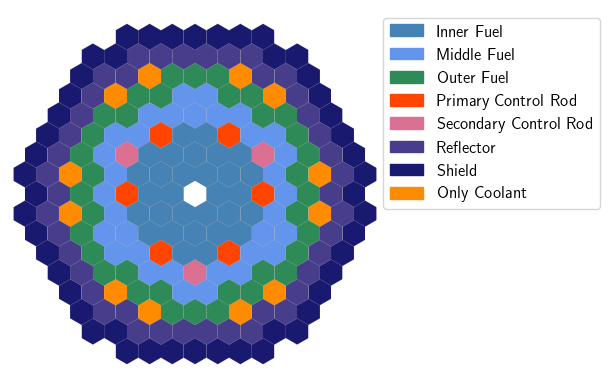

In [27]:
assmbly_plot = plt.imread('plots/core-xs-asmbly-wb.png')
plt.imshow(assmbly_plot)
plt.axis('off')
patches = []
for color in colors:
    patch = ptc.RegularPolygon((0, 0), 6, radius=1, color=color)
    patches.append(patch)
labels = ['Inner Fuel', 'Middle Fuel', 'Outer Fuel', 'Primary Control Rod', 'Secondary Control Rod', 'Reflector', 'Shield', 'Only Coolant']
# Add a legend with the proxy artist
plt.legend(patches, labels, bbox_to_anchor=(1.62,1.0))
plt.savefig('Core-Assmbly.png', dpi=1200, bbox_inches='tight')